In [2]:
# import libraries

# 1. to handle the data
import pandas as pd
import numpy as np

# to visualize the dataset
import matplotlib.pyplot as plt
import seaborn as sns


# To preprocess the data
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer
# import iterative imputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

#metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_absolute_error, mean_squared_error, r2_score

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
import warnings
warnings.filterwarnings('ignore')

In [2]:


# load the data from csv file placed locally in our pc
df = pd.read_csv('/kaggle/input/heart-disease-data/heart_disease_uci.csv')

# print the first 5 rows of the dataframe
df.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [3]:
df.info()

df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB


(920, 16)

<Axes: xlabel='age', ylabel='Count'>

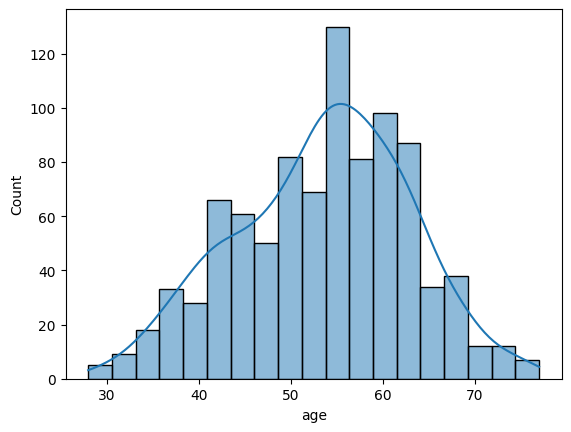

In [4]:
sns.histplot(df['age'], kde=True)


In [5]:
df['sex'].value_counts()

sex
Male      726
Female    194
Name: count, dtype: int64

In [6]:
df['cp'].value_counts()


cp
asymptomatic       496
non-anginal        204
atypical angina    174
typical angina      46
Name: count, dtype: int64

In [7]:
cp_num = pd.crosstab(df.cp,df.num)
cp_num

num,0,1,2,3,4
cp,,,,,
asymptomatic,104,197,89,83,23
atypical angina,150,19,2,3,0
non-anginal,131,37,14,18,4
typical angina,26,12,4,3,1


In [8]:
df.isnull().sum()[df.isnull().sum() > 0].sort_values(ascending=False)
missing_data_cols = df.isnull().sum()[df.isnull().sum() > 0].index.tolist()
missing_data_cols

['trestbps',
 'chol',
 'fbs',
 'restecg',
 'thalch',
 'exang',
 'oldpeak',
 'slope',
 'ca',
 'thal']

In [9]:
df['thal'].value_counts()

thal
normal               196
reversable defect    192
fixed defect          46
Name: count, dtype: int64

In [10]:
categorical_cols = ['thal', 'ca', 'slope', 'exang', 'restecg','fbs', 'cp', 'sex', 'num']
bool_cols = ['fbs', 'exang']
numeric_cols = ['oldpeak', 'thalch', 'chol', 'trestbps', 'age']

In [11]:
# define the function to impute the missing values in thal column

def impute_categorical_missing_data(passed_col):
    
    df_null = df[df[passed_col].isnull()]
    df_not_null = df[df[passed_col].notnull()]

    X = df_not_null.drop(passed_col, axis=1)
    y = df_not_null[passed_col]
    
    other_missing_cols = [col for col in missing_data_cols if col != passed_col]
    
    label_encoder = LabelEncoder()

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])

    if passed_col in bool_cols:
        y = label_encoder.fit_transform(y)
        
    iterative_imputer = IterativeImputer(estimator=RandomForestRegressor(random_state=42), add_indicator=True)

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf_classifier = RandomForestClassifier()

    rf_classifier.fit(X_train, y_train)

    y_pred = rf_classifier.predict(X_test)

    acc_score = accuracy_score(y_test, y_pred)

    print("The feature '"+ passed_col+ "' has been imputed with", round((acc_score * 100), 2), "accuracy\n")

    X = df_null.drop(passed_col, axis=1)

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass
                
    if len(df_null) > 0: 
        df_null[passed_col] = rf_classifier.predict(X)
        if passed_col in bool_cols:
            df_null[passed_col] = df_null[passed_col].map({0: False, 1: True})
        else:
            pass
    else:
        pass

    df_combined = pd.concat([df_not_null, df_null])
    
    return df_combined[passed_col]

def impute_continuous_missing_data(passed_col):
    
    df_null = df[df[passed_col].isnull()]
    df_not_null = df[df[passed_col].notnull()]

    X = df_not_null.drop(passed_col, axis=1)
    y = df_not_null[passed_col]
    
    other_missing_cols = [col for col in missing_data_cols if col != passed_col]
    
    label_encoder = LabelEncoder()

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])
    
    iterative_imputer = IterativeImputer(estimator=RandomForestRegressor(random_state=42), add_indicator=True)

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf_regressor = RandomForestRegressor()

    rf_regressor.fit(X_train, y_train)

    y_pred = rf_regressor.predict(X_test)

    print("MAE =", mean_absolute_error(y_test, y_pred), "\n")
    print("RMSE =", mean_squared_error(y_test, y_pred, squared=False), "\n")
    print("R2 =", r2_score(y_test, y_pred), "\n")

    X = df_null.drop(passed_col, axis=1)

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass
                
    if len(df_null) > 0: 
        df_null[passed_col] = rf_regressor.predict(X)
    else:
        pass

    df_combined = pd.concat([df_not_null, df_null])
    
    return df_combined[passed_col]

In [12]:
df.isnull().sum()[df.isnull().sum() > 0].sort_values(ascending=False)

ca          611
thal        486
slope       309
fbs          90
oldpeak      62
trestbps     59
thalch       55
exang        55
chol         30
restecg       2
dtype: int64

In [13]:
# impute missing values using our functions
for col in missing_data_cols:
    print("Missing Values", col, ":", str(round((df[col].isnull().sum() / len(df)) * 100, 2))+"%")
    if col in categorical_cols:
        df[col] = impute_categorical_missing_data(col)
    elif col in numeric_cols:
        df[col] = impute_continuous_missing_data(col)
    else:
        pass


Missing Values trestbps : 6.41%
MAE = 13.249132947976879 

RMSE = 17.03339460565355 

R2 = 0.09410009835697519 

Missing Values chol : 3.26%
MAE = 45.45797752808989 

RMSE = 64.40466413077358 

R2 = 0.6714108000486644 

Missing Values fbs : 9.78%
The feature 'fbs' has been imputed with 79.52 accuracy

Missing Values restecg : 0.22%
The feature 'restecg' has been imputed with 68.48 accuracy

Missing Values thalch : 5.98%
MAE = 16.85630057803468 

RMSE = 21.791235577104814 

R2 = 0.30951694518014783 

Missing Values exang : 5.98%
The feature 'exang' has been imputed with 77.46 accuracy

Missing Values oldpeak : 6.74%
MAE = 0.5648837209302325 

RMSE = 0.7879718667507728 

R2 = 0.4084664660397964 

Missing Values slope : 33.59%
The feature 'slope' has been imputed with 67.48 accuracy

Missing Values ca : 66.41%
The feature 'ca' has been imputed with 66.13 accuracy

Missing Values thal : 52.83%
The feature 'thal' has been imputed with 73.56 accuracy



In [14]:
df.isnull().sum()

id          0
age         0
sex         0
dataset     0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
num         0
dtype: int64

In [15]:
data = df.copy()
data.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [16]:
data.isnull().sum()

id          0
age         0
sex         0
dataset     0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
num         0
dtype: int64

In [17]:
data.to_csv('non_Null_Datadset.csv', index=False)

In [18]:
data["num"]

0      0
1      2
2      1
3      0
4      0
      ..
915    1
916    0
917    2
918    0
919    1
Name: num, Length: 920, dtype: int64

In [19]:
# In some of the features, there is space will will create problem later on. 
# So we rename those attributes to handle problems in the future.
data['thal'].replace({'fixed defect':'fixed_defect' , 'reversable defect': 'reversable_defect' }, inplace =True)
data['cp'].replace({'typical angina':'typical_angina', 'atypical angina': 'atypical_angina' }, inplace =True)
data['restecg'].replace({'normal': 'normal' , 'st-t abnormality': 'ST-T_wave_abnormality' , 'lv hypertrophy': 'left_ventricular_hypertrophy' }, inplace =True)

# Genrating New Dataset with Less Columns Which Are Necessary .
data_1 = data[['age','sex','cp','dataset', 'trestbps', 'chol', 'fbs','restecg' , 'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal']].copy()
# Some Changes in Target Variable | Only Two Categories (0,1) . 0 for No-Disease , 1 for Disease
data_1['target'] = ((data['num'] > 0)*1).copy()
# Encoding Sex 
data_1['sex'] = (data['sex'] == 'Male')*1
# Encoding Fbs and exang
data_1['fbs'] = (data['fbs'])*1
data_1['exang'] = (data['exang'])*1
# Renaming COlumns Names.
data_1.columns = ['age', 'sex', 'chest_pain_type','country' ,'resting_blood_pressure', 
              'cholesterol', 'fasting_blood_sugar','Restecg',
              'max_heart_rate_achieved', 'exercise_induced_angina', 
              'st_depression', 'st_slope_type', 'num_major_vessels', 
              'thalassemia_type', 'target']
# Load Data Sample 
data_1.head()

,age,sex,chest_pain_type,country,resting_blood_pressure,cholesterol,fasting_blood_sugar,Restecg,max_heart_rate_achieved,exercise_induced_angina,st_depression,st_slope_type,num_major_vessels,thalassemia_type,target
0,63,1,typical_angina,Cleveland,145.0,233.0,1,left_ventricular_hypertrophy,150.0,0,2.3,downsloping,0.0,fixed_defect,0
1,67,1,asymptomatic,Cleveland,160.0,286.0,0,left_ventricular_hypertrophy,108.0,1,1.5,flat,3.0,normal,1
2,67,1,asymptomatic,Cleveland,120.0,229.0,0,left_ventricular_hypertrophy,129.0,1,2.6,flat,2.0,reversable_defect,1
3,37,1,non-anginal,Cleveland,130.0,250.0,0,normal,187.0,0,3.5,downsloping,0.0,normal,0
4,41,0,atypical_angina,Cleveland,130.0,204.0,0,left_ventricular_hypertrophy,172.0,0,1.4,upsloping,0.0,normal,0


In [20]:
data_1.to_csv('transformed_non_Null_Datadset.csv', index=False)

In [21]:
def train_random_forest(data, target):
    # Dictionary to store LabelEncoders for each categorical column
    label_encoders = {}

    # split the data into X and y
    X = data.drop(target, axis=1)
    y = data[target]

    # Create a new LabelEncoder for each categorical column
    for col in X.select_dtypes(include=['object', 'category']).columns:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])
        label_encoders[col] = le

    # split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

    # Scaling Data
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Define the Random Forest model
    rf_model = RandomForestClassifier(random_state=0,class_weight='balanced')

    # Define hyperparameters for tuning
    param_grid = {
        'n_estimators': [50, 100, 150],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    # Perform GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    # Get the best model and parameters
    best_rf_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Print the best hyperparameters
    print('Best Hyperparameters:')
    print(best_params)

    # Train the model on the full training set
    best_rf_model.fit(X_train, y_train)

    # Evaluate the model on the test set
    y_pred = best_rf_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print(f'Accuracy on Test Set: {accuracy:.2f}')

    # Inverse transform at the End
    # Loop through each column to decode the data
    for col, le in label_encoders.items():
        # Use the inverse_transform method to decode the column in both training and test sets
        X[col] = le.inverse_transform(X[col])

    return best_rf_model, best_params, accuracy

In [22]:
train_random_forest(data_1, 'target')

Best Hyperparameters:
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Accuracy on Test Set: 0.84


(RandomForestClassifier(class_weight='balanced', min_samples_split=5,
                        n_estimators=50, random_state=0),
 {'max_depth': None,
  'min_samples_leaf': 1,
  'min_samples_split': 5,
  'n_estimators': 50},
 0.8442028985507246)

In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

def prepare_data_for_model(df, target_col='target', test_size=0.2, random_state=42, scale_method='standard'):
    """
    Veriyi ML modeli için hazırlar: Encoding -> Splitting -> Scaling
    
    Args:
        df (pd.DataFrame): İşlenecek veri seti (data_1)
        target_col (str): Hedef değişkenin adı
        test_size (float): Test seti oranı
        random_state (int): Tekrarlanabilirlik için seed
        scale_method (str): 'standard' (StandardScaler) veya 'minmax' (MinMaxScaler)
    
    Returns:
        X_train, X_test, y_train, y_test: Modele girmeye hazır setler
        scaler: Kullanılan ölçekleyici (daha sonra yeni veriyi scale etmek için)
        encoders: Kullanılan label encoder sözlüğü (geri dönüşüm için)
    """
    
    # 1. Veriyi kopyala (Orijinali bozmamak için)
    data = df.copy()
    
    # 2. Feature (X) ve Target (y) Ayrımı
    X = data.drop(target_col, axis=1)
    y = data[target_col]
    
    # 3. Categorical Encoding (Label Encoding)
    # Otomatik olarak 'object' veya 'category' tipindeki kolonları bulur
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns
    encoders = {}
    
    for col in categorical_cols:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])
        encoders[col] = le  # Encoder'ı sakla (ileride lazım olabilir)
        
    # 4. Train - Test Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    # 5. Scaling (Ölçeklendirme)
    # ÖNEMLİ: Scaler sadece X_train üzerine fit edilir! X_test sadece transform edilir.
    if scale_method == 'minmax':
        scaler = MinMaxScaler()
    else:
        scaler = StandardScaler() # Varsayılan olarak bunu öneririm
        
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    print(f"Veri Hazır!\nX_train shape: {X_train.shape}\nX_test shape: {X_test.shape}")
    
    return X_train, X_test, y_train, y_test, scaler, encoders

# KULLANIMI:
# data_1 senin önceki kodundan gelen dataframe
X_train, X_test, y_train, y_test, scaler, encoders = prepare_data_for_model(data_1, target_col='target')

Veri Hazır!
X_train shape: (736, 14)
X_test shape: (184, 14)


In [24]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# 1. Veriyi hazırla (Önceki fonksiyonu kullanarak)
# KNN genelde 'minmax' scaler ile biraz daha iyi çalışabilir, mesafe hesabı için.
X_train, X_test, y_train, y_test, scaler, encoders = prepare_data_for_model(data_1, scale_method='minmax')

# 2. KNN Modelini Tanımla
# n_neighbors=5 standart başlangıçtır, bunu değiştirmeyi deneyebilirsin.
knn_model = KNeighborsClassifier(n_neighbors=5)

# 3. Modeli Eğit
knn_model.fit(X_train, y_train)

# 4. Tahmin Yap ve Ölç
y_pred = knn_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"KNN Doğruluk Oranı (Accuracy): {accuracy:.2f}")

Veri Hazır!
X_train shape: (736, 14)
X_test shape: (184, 14)
KNN Doğruluk Oranı (Accuracy): 0.88


In [25]:
import numpy as np

class LogisticRegressionFromScratch:
    def __init__(self, learning_rate=0.01, n_iters=1000):
        self.lr = learning_rate
        self.n_iters = n_iters
        self.weights = None
        self.bias = None

    # 1. Sigmoid Fonksiyonu: Çıktıyı 0 ile 1 arasına sıkıştırır
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        # X: (örnek_sayısı, özellik_sayısı)
        n_samples, n_features = X.shape

        # Ağırlıkları (weights) ve bias'ı sıfırla başlatıyoruz
        self.weights = np.zeros(n_features)
        self.bias = 0

        # Gradient Descent (Öğrenme Döngüsü)
        for _ in range(self.n_iters):
            # 1. Linear Model (z = w*x + b)
            linear_model = np.dot(X, self.weights) + self.bias
            
            # 2. Tahmin (Activation Function)
            y_predicted = self.sigmoid(linear_model)

            # 3. Gradients (Türev Hesabı: Hata ne yönde?)
            # Bu formüller matematiğin "Türev" kısmından gelir.
            dw = (1 / n_samples) * np.dot(X.T, (y_predicted - y))
            db = (1 / n_samples) * np.sum(y_predicted - y)

            # 4. Update Parameters (Ağırlıkları güncelle)
            # Ağırlığı hatanın tersi yönünde, learning_rate kadar kaydırıyoruz
            self.weights -= self.lr * dw
            self.bias -= self.lr * db

    def predict(self, X):
        # Eğitilmiş ağırlıklarla tahmin yap
        linear_model = np.dot(X, self.weights) + self.bias
        y_predicted = self.sigmoid(linear_model)
        
        # Olasılık 0.5'ten büyükse 1, değilse 0 döndür (Threshold)
        y_predicted_cls = [1 if i > 0.5 else 0 for i in y_predicted]
        return np.array(y_predicted_cls)

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# 1. Veriyi Hazırla (Senin data_1 setin ile)
# Logistic Regression için StandardScaler (scale_method='standard') daha iyidir.
X_train, X_test, y_train, y_test, scaler, encoders = prepare_data_for_model(data_1, scale_method='standard')

# --- MODEL 1: BİZİM YAZDIĞIMIZ (FROM SCRATCH) ---
print("--- Custom Model Training ---")
my_model = LogisticRegressionFromScratch(learning_rate=0.01, n_iters=2000)
my_model.fit(X_train, y_train)
my_preds = my_model.predict(X_test)
my_acc = accuracy_score(y_test, my_preds)

# --- MODEL 2: SKLEARN (HAZIR KÜTÜPHANE) ---
print("--- Sklearn Model Training ---")
sk_model = LogisticRegression(random_state=42) # default parametreler
sk_model.fit(X_train, y_train)
sk_preds = sk_model.predict(X_test)
sk_acc = accuracy_score(y_test, sk_preds)

# --- SONUÇLAR ---
print("\n" + "="*30)
print(f"Bizim Modelin Doğruluğu: %{my_acc * 100:.2f}")
print(f"Sklearn Modelin Doğruluğu: %{sk_acc * 100:.2f}")
print("="*30)

# Farkı kontrol et
if abs(my_acc - sk_acc) < 0.05:
    print("Harika! Modelin mantığını doğru kurmuşsun, sonuçlar Sklearn'e çok yakın.")
else:
    print("Sonuçlarda fark var. Learning Rate veya Iteration sayısını artırmayı deneyebilirsin.")

Veri Hazır!
X_train shape: (736, 14)
X_test shape: (184, 14)
--- Custom Model Training ---
--- Sklearn Model Training ---

Bizim Modelin Doğruluğu: %82.07
Sklearn Modelin Doğruluğu: %81.52
Harika! Modelin mantığını doğru kurmuşsun, sonuçlar Sklearn'e çok yakın.


In [27]:
import numpy as np

class LogisticRegressionL2:
    def __init__(self, learning_rate=0.01, n_iters=1000, lambda_param=0.1):
        self.lr = learning_rate
        self.n_iters = n_iters
        self.lambda_param = lambda_param  # L2 Regularization katsayısı (Alpha)
        self.weights = None
        self.bias = None

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.n_iters):
            linear_model = np.dot(X, self.weights) + self.bias
            y_predicted = self.sigmoid(linear_model)

            # --- L2 REGULARIZATION FARKI BURADA ---
            # Türev hesabına (lambda_param * weights) ekleniyor.
            # Not: Bias terimi genellikle regularize edilmez, o yüzden ona eklemiyoruz.
            dw = (1 / n_samples) * (np.dot(X.T, (y_predicted - y)) + 2 * self.lambda_param * self.weights)
            db = (1 / n_samples) * np.sum(y_predicted - y)

            self.weights -= self.lr * dw
            self.bias -= self.lr * db

    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        y_predicted = self.sigmoid(linear_model)
        y_predicted_cls = [1 if i > 0.5 else 0 for i in y_predicted]
        return np.array(y_predicted_cls)

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# 1. Veriyi Hazırla (Senin data_1 setin ile)
# Logistic Regression için StandardScaler (scale_method='standard') daha iyidir.
X_train, X_test, y_train, y_test, scaler, encoders = prepare_data_for_model(data_1, scale_method='standard')

# --- MODEL 1: BİZİM YAZDIĞIMIZ (FROM SCRATCH) ---
print("--- Custom Model Training ---")
my_model = LogisticRegressionL2(learning_rate=0.01, n_iters=2000)
my_model.fit(X_train, y_train)
my_preds = my_model.predict(X_test)
my_acc = accuracy_score(y_test, my_preds)

# --- MODEL 2: SKLEARN (HAZIR KÜTÜPHANE) ---
print("--- Sklearn Model Training ---")
sk_model = LogisticRegression(random_state=42) # default parametreler
sk_model.fit(X_train, y_train)
sk_preds = sk_model.predict(X_test)
sk_acc = accuracy_score(y_test, sk_preds)

# --- SONUÇLAR ---
print("\n" + "="*30)
print(f"Bizim Modelin Doğruluğu: %{my_acc * 100:.2f}")
print(f"Sklearn Modelin Doğruluğu: %{sk_acc * 100:.2f}")
print("="*30)

# Farkı kontrol et
if abs(my_acc - sk_acc) < 0.05:
    print("Harika! Modelin mantığını doğru kurmuşsun, sonuçlar Sklearn'e çok yakın.")
else:
    print("Sonuçlarda fark var. Learning Rate veya Iteration sayısını artırmayı deneyebilirsin.")

Veri Hazır!
X_train shape: (736, 14)
X_test shape: (184, 14)
--- Custom Model Training ---
--- Sklearn Model Training ---

Bizim Modelin Doğruluğu: %82.07
Sklearn Modelin Doğruluğu: %81.52
Harika! Modelin mantığını doğru kurmuşsun, sonuçlar Sklearn'e çok yakın.


In [29]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# ==========================================
# 1. BİZİM YAZDIĞIMIZ MODEL (L2 REGULARIZATION İLE)
# ==========================================
class LogisticRegressionL2:
    def __init__(self, learning_rate=0.01, n_iters=1000, lambda_param=0.1):
        self.lr = learning_rate
        self.n_iters = n_iters
        self.lambda_param = lambda_param  # L2 Regularization gücü
        self.weights = None
        self.bias = None
        self.loss_history = []

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0
        self.loss_history = []

        for _ in range(self.n_iters):
            linear_model = np.dot(X, self.weights) + self.bias
            y_predicted = self.sigmoid(linear_model)

            # Gradient Calculation (L2 Penalty Dahil)
            dw = (1 / n_samples) * (np.dot(X.T, (y_predicted - y)) + 2 * self.lambda_param * self.weights)
            db = (1 / n_samples) * np.sum(y_predicted - y)

            # Update Parameters
            self.weights -= self.lr * dw
            self.bias -= self.lr * db

    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        y_predicted = self.sigmoid(linear_model)
        return [1 if i > 0.5 else 0 for i in y_predicted]

# ==========================================
# 2. VERİYİ HAZIRLA
# ==========================================
# Önceki fonksiyonunu kullanıyoruz (StandardScaler LogReg için kritiktir!)
X_train, X_test, y_train, y_test, scaler, encoders = prepare_data_for_model(data_1, scale_method='standard')

print(f"Eğitim Seti Boyutu: {X_train.shape}")
print("-" * 40)

# ==========================================
# 3. CUSTOM MODEL İÇİN HYPERPARAMETER TUNING
# ==========================================
print("CUSTOM MODEL TUNING BAŞLIYOR...")

# Denenecek parametreler
learning_rates = [0.1, 0.01, 0.001]
n_iters_list = [1000, 2500, 5000]
lambdas = [0.0, 0.1, 1.0] # 0.0 = Regularization yok, 1.0 = Güçlü

best_custom_score = 0
best_custom_params = {}

# Manuel Grid Search Döngüsü
for lr in learning_rates:
    for iters in n_iters_list:
        for lam in lambdas:
            model = LogisticRegressionL2(learning_rate=lr, n_iters=iters, lambda_param=lam)
            model.fit(X_train, y_train)
            preds = model.predict(X_test)
            acc = accuracy_score(y_test, preds)
            
            if acc > best_custom_score:
                best_custom_score = acc
                best_custom_params = {'lr': lr, 'iters': iters, 'lambda': lam}

print(f"✅ Custom Model En İyi Skor: %{best_custom_score*100:.2f}")
print(f"✅ En İyi Parametreler: {best_custom_params}")
print("-" * 40)

# ==========================================
# 4. SKLEARN MODEL İÇİN HYPERPARAMETER TUNING
# ==========================================
print("SKLEARN MODEL TUNING BAŞLIYOR...")

# Sklearn Parametre Izgarası
# Not: Sklearn'de 'C' parametres, lambda'nın tersidir (C = 1/lambda). 
# Küçük C = Güçlü Regularization, Büyük C = Zayıf Regularization.
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100], 
    'solver': ['liblinear', 'lbfgs'], # liblinear küçük veri setleri için iyidir
    'max_iter': [100, 200]
}

sk_model = LogisticRegression(random_state=42)

# GridSearchCV Otomatik Tarama Yapar
grid_search = GridSearchCV(sk_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_sk_model = grid_search.best_estimator_
best_sk_score = accuracy_score(y_test, best_sk_model.predict(X_test))

print(f"✅ Sklearn Model En İyi Skor: %{best_sk_score*100:.2f}")
print(f"✅ En İyi Parametreler: {grid_search.best_params_}")

# ==========================================
# 5. KARŞILAŞTIRMA
# ==========================================
print("\n" + "="*40)
print(f"FINAL CUSTOM ACCURACY : %{best_custom_score*100:.2f}")
print(f"FINAL SKLEARN ACCURACY: %{best_sk_score*100:.2f}")
print("="*40)

Veri Hazır!
X_train shape: (736, 14)
X_test shape: (184, 14)
Eğitim Seti Boyutu: (736, 14)
----------------------------------------
CUSTOM MODEL TUNING BAŞLIYOR...
✅ Custom Model En İyi Skor: %83.70
✅ En İyi Parametreler: {'lr': 0.01, 'iters': 1000, 'lambda': 0.0}
----------------------------------------
SKLEARN MODEL TUNING BAŞLIYOR...
✅ Sklearn Model En İyi Skor: %80.98
✅ En İyi Parametreler: {'C': 0.1, 'max_iter': 100, 'solver': 'lbfgs'}

FINAL CUSTOM ACCURACY : %83.70
FINAL SKLEARN ACCURACY: %80.98


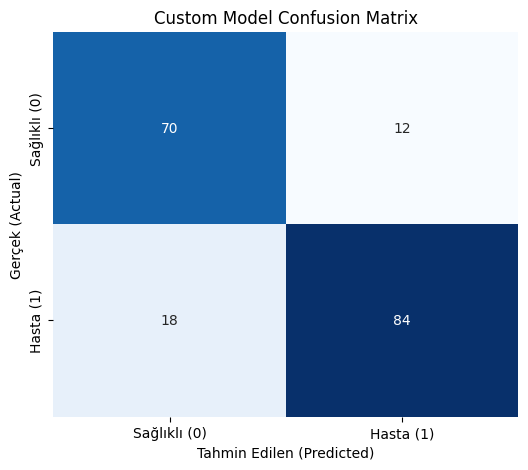

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. En iyi parametrelerle senin modelini tekrar eğitip tahmin alalım
best_custom_model = LogisticRegressionL2(learning_rate=0.01, n_iters=1000, lambda_param=0.0)
best_custom_model.fit(X_train, y_train)
y_pred_custom = best_custom_model.predict(X_test)

# 2. Confusion Matrix Oluştur
cm = confusion_matrix(y_test, y_pred_custom)

# 3. Görselleştirme
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Custom Model Confusion Matrix')
plt.xlabel('Tahmin Edilen (Predicted)')
plt.ylabel('Gerçek (Actual)')
plt.xticks([0.5, 1.5], ['Sağlıklı (0)', 'Hasta (1)'])
plt.yticks([0.5, 1.5], ['Sağlıklı (0)', 'Hasta (1)'])
plt.show()

In [31]:
import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# ==========================================
# 0. VERİYİ HAZIRLA
# ==========================================
# Burada, senin zaten yazmış olduğun fonksiyonu kullanıyoruz:
# X_train, X_test, y_train, y_test, scaler, encoders = prepare_data_for_model(data_1, scale_method='standard')

X_train, X_test, y_train, y_test, scaler, encoders = prepare_data_for_model(
    data_1,
    scale_method='standard'
)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape : {X_test.shape}")
print("-" * 50)

# ==========================================
# 1. SKLEARN UYUMLU CUSTOM LOGISTIC REGRESSION (L2)
# ==========================================
class LogisticRegressionL2(BaseEstimator, ClassifierMixin):
    """
    Sıfırdan yazılmış Logistic Regression (L2 Regularization ile),
    sklearn'in GridSearchCV'si ile uyumlu hale getirilmiş hali.
    """

    def __init__(self, learning_rate=0.01, n_iters=1000, lambda_param=0.1):
        self.learning_rate = learning_rate
        self.n_iters = n_iters
        self.lambda_param = lambda_param

        # Fit sonrası set edilecek değişkenler
        self.weights_ = None
        self.bias_ = None
        self.loss_history_ = []

    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        # X: (n_samples, n_features)
        # y: (n_samples,) veya (n_samples, 1)
        X = np.array(X)
        y = np.array(y).ravel()  # Her ihtimale karşı 1D yap

        n_samples, n_features = X.shape

        # Ağırlıkları başlat
        self.weights_ = np.zeros(n_features)
        self.bias_ = 0.0
        self.loss_history_ = []

        lr = self.learning_rate
        lam = self.lambda_param

        for _ in range(self.n_iters):
            # Lineer model
            linear_model = np.dot(X, self.weights_) + self.bias_
            y_pred = self._sigmoid(linear_model)

            # Gradientler (L2 penalty dahil — bias'a penalty eklemiyoruz)
            dw = (1 / n_samples) * (np.dot(X.T, (y_pred - y)) + 2 * lam * self.weights_)
            db = (1 / n_samples) * np.sum(y_pred - y)

            # Güncelleme
            self.weights_ -= lr * dw
            self.bias_    -= lr * db

        return self  # sklearn uyumluluğu için

    def predict_proba(self, X):
        """
        Sklearn API ile uyumlu olması için.
        Çıkış: shape (n_samples, 2) -> [P(class=0), P(class=1)]
        """
        X = np.array(X)
        linear_model = np.dot(X, self.weights_) + self.bias_
        y_prob_1 = self._sigmoid(linear_model)
        y_prob_0 = 1 - y_prob_1
        return np.vstack([y_prob_0, y_prob_1]).T

    def predict(self, X):
        """
        Sklearn'in beklediği predict metodu.
        """
        proba = self.predict_proba(X)[:, 1]  # class=1 olasılığı
        return (proba > 0.5).astype(int)


# ==========================================
# 2. CUSTOM MODEL İÇİN GRIDSEARCHCV (SADECE TRAIN ÜZERİNDE CV)
# ==========================================
print("CUSTOM MODEL (GridSearchCV ile) TUNING BAŞLIYOR...")

custom_param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'n_iters': [1000, 2500, 5000],
    'lambda_param': [0.0, 0.1, 1.0]
}

custom_base_model = LogisticRegressionL2()

grid_search_custom = GridSearchCV(
    estimator=custom_base_model,
    param_grid=custom_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_search_custom.fit(X_train, y_train)

best_custom_model = grid_search_custom.best_estimator_
best_custom_params = grid_search_custom.best_params_
best_custom_val_score = grid_search_custom.best_score_  # CV skoru (train içi)

# Test seti performansı (test'e sadece 1 kez dokunuyoruz)
best_custom_test_preds = best_custom_model.predict(X_test)
best_custom_test_acc = accuracy_score(y_test, best_custom_test_preds)

print(f"✅ Custom Model (CV) En İyi Train-CV Skoru: %{best_custom_val_score*100:.2f}")
print(f"✅ Custom Model En İyi Parametreler: {best_custom_params}")
print(f"✅ Custom Model Test Accuracy         : %{best_custom_test_acc*100:.2f}")
print("-" * 50)

# ==========================================
# 3. SKLEARN LOGISTICREGRESSION İÇİN GRIDSEARCHCV
# ==========================================
print("SKLEARN MODEL TUNING BAŞLIYOR...")

sk_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs'],
    'max_iter': [100, 200]
}

sk_base_model = LogisticRegression(
    random_state=42,
    penalty='l2'
)

grid_search_sk = GridSearchCV(
    estimator=sk_base_model,
    param_grid=sk_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_search_sk.fit(X_train, y_train)

best_sk_model = grid_search_sk.best_estimator_
best_sk_params = grid_search_sk.best_params_
best_sk_val_score = grid_search_sk.best_score_

best_sk_test_preds = best_sk_model.predict(X_test)
best_sk_test_acc = accuracy_score(y_test, best_sk_test_preds)

print(f"✅ Sklearn Model (CV) En İyi Train-CV Skoru: %{best_sk_val_score*100:.2f}")
print(f"✅ Sklearn Model En İyi Parametreler       : {best_sk_params}")
print(f"✅ Sklearn Model Test Accuracy             : %{best_sk_test_acc*100:.2f}")
print("-" * 50)

# ==========================================
# 4. FİNAL KARŞILAŞTIRMA (ADİL ŞEKİLDE)
# ==========================================
print("\n" + "="*50)
print(f"FINAL CUSTOM  TEST ACCURACY : %{best_custom_test_acc*100:.2f}")
print(f"FINAL SKLEARN TEST ACCURACY : %{best_sk_test_acc*100:.2f}")
print("="*50)

Veri Hazır!
X_train shape: (736, 14)
X_test shape: (184, 14)
X_train shape: (736, 14)
X_test shape : (184, 14)
--------------------------------------------------
CUSTOM MODEL (GridSearchCV ile) TUNING BAŞLIYOR...
✅ Custom Model (CV) En İyi Train-CV Skoru: %82.47
✅ Custom Model En İyi Parametreler: {'lambda_param': 1.0, 'learning_rate': 0.01, 'n_iters': 5000}
✅ Custom Model Test Accuracy         : %81.52
--------------------------------------------------
SKLEARN MODEL TUNING BAŞLIYOR...
✅ Sklearn Model (CV) En İyi Train-CV Skoru: %82.61
✅ Sklearn Model En İyi Parametreler       : {'C': 0.1, 'max_iter': 100, 'solver': 'lbfgs'}
✅ Sklearn Model Test Accuracy             : %80.98
--------------------------------------------------

FINAL CUSTOM  TEST ACCURACY : %81.52
FINAL SKLEARN TEST ACCURACY : %80.98


Custom Model Metrics:
  Accuracy: 0.8152
  Precision: 0.8469
  Recall: 0.8137
  F1-Score: 0.8300
  ROC-AUC: 0.9020

Sklearn Model Metrics:
  Accuracy: 0.8098
  Precision: 0.8384
  Recall: 0.8137
  F1-Score: 0.8259
  ROC-AUC: 0.9041

Metrix Tablosu:
             Custom   Sklearn
Accuracy   0.815217  0.809783
Precision  0.846939  0.838384
Recall     0.813725  0.813725
F1-Score   0.830000  0.825871
ROC-AUC    0.901961  0.904113


<Figure size 800x500 with 0 Axes>

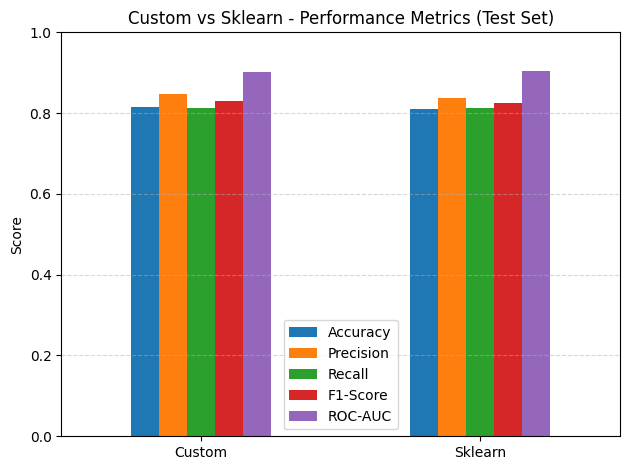

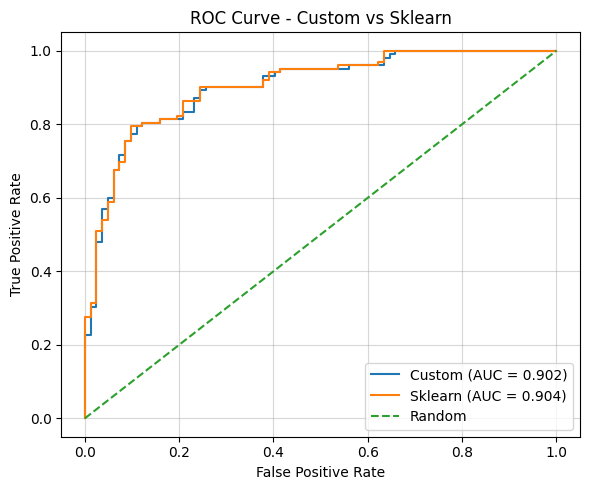

In [32]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve
)
import matplotlib.pyplot as plt

# ==========================================
# 1. TAHMİNLERİ AL (Test setinde)
# ==========================================
y_test_true = y_test  # kısalık için

# Custom model
y_pred_custom = best_custom_model.predict(X_test)
y_prob_custom = best_custom_model.predict_proba(X_test)[:, 1]  # class=1 olasılığı

# Sklearn model
y_pred_sk = best_sk_model.predict(X_test)
y_prob_sk = best_sk_model.predict_proba(X_test)[:, 1]

# ==========================================
# 2. METRİKLERİ HESAPLA
# ==========================================
def compute_metrics(y_true, y_pred, y_prob):
    return {
        "Accuracy":  accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, average="binary"),
        "Recall":    recall_score(y_true, y_pred, average="binary"),
        "F1-Score":  f1_score(y_true, y_pred, average="binary"),
        "ROC-AUC":   roc_auc_score(y_true, y_prob),
    }

metrics_custom = compute_metrics(y_test_true, y_pred_custom, y_prob_custom)
metrics_sk     = compute_metrics(y_test_true, y_pred_sk,     y_prob_sk)

print("Custom Model Metrics:")
for k, v in metrics_custom.items():
    print(f"  {k}: {v:.4f}")

print("\nSklearn Model Metrics:")
for k, v in metrics_sk.items():
    print(f"  {k}: {v:.4f}")

# ==========================================
# 3. METRİKLERİ TEK TABLODA GÖSTER (pandas)
# ==========================================
metrics_df = pd.DataFrame({
    "Custom": metrics_custom,
    "Sklearn": metrics_sk
})

print("\nMetrix Tablosu:")
print(metrics_df)

# ==========================================
# 4. METRİKLERİ BAR GRAFİK OLARAK ÇİZDİR
# ==========================================
plt.figure(figsize=(8, 5))
metrics_df.T.plot(kind="bar")
plt.title("Custom vs Sklearn - Performance Metrics (Test Set)")
plt.ylabel("Score")
plt.ylim(0, 1.0)
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# ==========================================
# 5. ROC EĞRİLERİ
# ==========================================
fpr_custom, tpr_custom, _ = roc_curve(y_test_true, y_prob_custom)
fpr_sk, tpr_sk, _         = roc_curve(y_test_true, y_prob_sk)

plt.figure(figsize=(6, 5))
plt.plot(fpr_custom, tpr_custom, label=f"Custom (AUC = {metrics_custom['ROC-AUC']:.3f})")
plt.plot(fpr_sk,     tpr_sk,     label=f"Sklearn (AUC = {metrics_sk['ROC-AUC']:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Custom vs Sklearn")
plt.legend(loc="lower right")
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

In [39]:
"""
=============================================================================
GAUSSIAN NAIVE BAYES CLASSIFIER - IMPLEMENTED FROM SCRATCH
=============================================================================
This implementation is for heart disease prediction.
No ML libraries (sklearn, etc.) are used for the algorithm itself.
Sklearn is ONLY used at the end for verification purposes.

Author: [Your Name]
Course: [Your Course]
Task: Implement ML algorithm from scratch for heart disease classification
=============================================================================
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)


# =============================================================================
# SECTION 1: DATA PREPROCESSING (From Scratch)
# =============================================================================

class DataPreprocessor:
    """
    Handles all data preprocessing without using sklearn.
    - Label encoding for categorical variables
    - Feature normalization (standardization)
    """
    
    def __init__(self):
        self.label_encoders = {}  # Store mappings for each categorical column
        self.means = None         # For standardization
        self.stds = None          # For standardization
    
    def fit_transform_labels(self, df, categorical_columns):
        """
        Convert categorical text columns to numerical values.
        Example: 'typical_angina' -> 0, 'atypical_angina' -> 1, etc.
        """
        df_encoded = df.copy()
        
        for col in categorical_columns:
            unique_values = df[col].unique()
            # Create mapping: {'typical_angina': 0, 'atypical_angina': 1, ...}
            mapping = {val: idx for idx, val in enumerate(unique_values)}
            self.label_encoders[col] = mapping
            # Apply mapping
            df_encoded[col] = df[col].map(mapping)
        
        return df_encoded
    
    def transform_labels(self, df, categorical_columns):
        """Apply existing label encodings to new data."""
        df_encoded = df.copy()
        for col in categorical_columns:
            df_encoded[col] = df[col].map(self.label_encoders[col])
        return df_encoded
    
    def fit_standardize(self, X):
        """
        Calculate mean and std for standardization.
        Standardization: z = (x - mean) / std
        This helps Gaussian NB work better when features have different scales.
        """
        self.means = np.mean(X, axis=0)
        self.stds = np.std(X, axis=0)
        # Avoid division by zero
        self.stds[self.stds == 0] = 1
        return (X - self.means) / self.stds
    
    def transform_standardize(self, X):
        """Apply standardization using pre-computed mean and std."""
        return (X - self.means) / self.stds


# =============================================================================
# SECTION 2: GAUSSIAN NAIVE BAYES CLASSIFIER (From Scratch)
# =============================================================================

class GaussianNaiveBayes:
    """
    Gaussian Naive Bayes Classifier implemented from scratch.
    
    Theory:
    -------
    Bayes' Theorem: P(y|X) = P(X|y) * P(y) / P(X)
    
    We want to find the class y that maximizes P(y|X).
    Since P(X) is constant for all classes, we maximize: P(X|y) * P(y)
    
    Naive Assumption: Features are independent given the class.
    P(X|y) = P(x1|y) * P(x2|y) * ... * P(xn|y)
    
    Gaussian Assumption: Each P(xi|y) follows a Gaussian (Normal) distribution.
    P(xi|y) = (1 / sqrt(2*pi*var)) * exp(-(xi - mean)^2 / (2*var))
    
    We use log probabilities to avoid numerical underflow:
    log P(y|X) ∝ log P(y) + Σ log P(xi|y)
    """
    
    def __init__(self, var_smoothing=1e-9):
        """
        var_smoothing: Small value added to variance for numerical stability.
                      Prevents division by zero when a feature has zero variance.
        """
        self.var_smoothing = var_smoothing
        self._classes = None
        self._mean = None
        self._var = None
        self._priors = None
    
    def fit(self, X, y):
        """
        Train the Gaussian Naive Bayes model.
        
        Parameters:
        -----------
        X : numpy array of shape (n_samples, n_features)
            Training features
        y : numpy array of shape (n_samples,)
            Training labels (0 or 1 for binary classification)
        """
        n_samples, n_features = X.shape
        self._classes = np.unique(y)
        n_classes = len(self._classes)
        
        # Initialize arrays to store statistics for each class
        self._mean = np.zeros((n_classes, n_features))
        self._var = np.zeros((n_classes, n_features))
        self._priors = np.zeros(n_classes)
        
        # Calculate statistics for each class
        for idx, c in enumerate(self._classes):
            # Get all samples belonging to class c
            X_c = X[y == c]
            
            # Mean of each feature for this class
            self._mean[idx, :] = X_c.mean(axis=0)
            
            # Variance of each feature for this class (add smoothing)
            self._var[idx, :] = X_c.var(axis=0) + self.var_smoothing
            
            # Prior probability P(y=c) = count(y=c) / total_samples
            self._priors[idx] = X_c.shape[0] / float(n_samples)
        
        return self
    
    def predict(self, X):
        """Predict class labels for samples in X."""
        return np.array([self._predict_single(x) for x in X])
    
    def predict_proba(self, X):
        """
        Predict class probabilities for samples in X.
        Returns probability for each class.
        This is needed for ROC-AUC calculation.
        """
        return np.array([self._predict_proba_single(x) for x in X])
    
    def _predict_single(self, x):
        """Predict class for a single sample."""
        posteriors = []
        
        for idx, c in enumerate(self._classes):
            # Log of prior probability
            log_prior = np.log(self._priors[idx])
            
            # Sum of log likelihoods (log of Gaussian PDF)
            log_likelihood = np.sum(self._log_gaussian_pdf(idx, x))
            
            # Log posterior (unnormalized)
            posterior = log_prior + log_likelihood
            posteriors.append(posterior)
        
        # Return class with highest posterior
        return self._classes[np.argmax(posteriors)]
    
    def _predict_proba_single(self, x):
        """Get probability estimates for a single sample."""
        log_posteriors = []
        
        for idx, c in enumerate(self._classes):
            log_prior = np.log(self._priors[idx])
            log_likelihood = np.sum(self._log_gaussian_pdf(idx, x))
            log_posteriors.append(log_prior + log_likelihood)
        
        # Convert log posteriors to probabilities using softmax
        # Subtract max for numerical stability
        log_posteriors = np.array(log_posteriors)
        log_posteriors -= np.max(log_posteriors)
        posteriors = np.exp(log_posteriors)
        return posteriors / posteriors.sum()
    
    def _log_gaussian_pdf(self, class_idx, x):
        """
        Calculate log of Gaussian PDF for numerical stability.
        
        log P(x|class) = -0.5 * log(2*pi*var) - (x-mean)^2 / (2*var)
        """
        mean = self._mean[class_idx]
        var = self._var[class_idx]
        
        # Log of Gaussian PDF (more stable than computing PDF then taking log)
        log_prob = -0.5 * np.log(2 * np.pi * var) - ((x - mean) ** 2) / (2 * var)
        return log_prob


# =============================================================================
# SECTION 3: EVALUATION METRICS (From Scratch)
# =============================================================================

class MetricsCalculator:
    """
    Calculate all required evaluation metrics from scratch.
    - Accuracy
    - Precision
    - Recall
    - F1-Score
    - ROC-AUC
    """
    
    @staticmethod
    def confusion_matrix(y_true, y_pred):
        """
        Calculate confusion matrix components.
        
        Returns: tp, tn, fp, fn
        """
        tp = np.sum((y_true == 1) & (y_pred == 1))
        tn = np.sum((y_true == 0) & (y_pred == 0))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        fn = np.sum((y_true == 1) & (y_pred == 0))
        return tp, tn, fp, fn
    
    @staticmethod
    def accuracy(y_true, y_pred):
        """Accuracy = (TP + TN) / (TP + TN + FP + FN)"""
        tp, tn, fp, fn = MetricsCalculator.confusion_matrix(y_true, y_pred)
        return (tp + tn) / (tp + tn + fp + fn)
    
    @staticmethod
    def precision(y_true, y_pred):
        """Precision = TP / (TP + FP) - How many predicted positives are actually positive"""
        tp, tn, fp, fn = MetricsCalculator.confusion_matrix(y_true, y_pred)
        return tp / (tp + fp) if (tp + fp) > 0 else 0.0
    
    @staticmethod
    def recall(y_true, y_pred):
        """Recall = TP / (TP + FN) - How many actual positives were correctly identified"""
        tp, tn, fp, fn = MetricsCalculator.confusion_matrix(y_true, y_pred)
        return tp / (tp + fn) if (tp + fn) > 0 else 0.0
    
    @staticmethod
    def f1_score(y_true, y_pred):
        """F1 = 2 * (Precision * Recall) / (Precision + Recall)"""
        prec = MetricsCalculator.precision(y_true, y_pred)
        rec = MetricsCalculator.recall(y_true, y_pred)
        return 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0.0
    
    @staticmethod
    def roc_auc(y_true, y_proba):
        """
        Calculate ROC-AUC (Area Under the ROC Curve) from scratch.
        
        ROC Curve plots True Positive Rate vs False Positive Rate at various thresholds.
        AUC is the area under this curve (1.0 = perfect, 0.5 = random).
        
        Method: Use the trapezoidal rule to calculate area.
        """
        # Get probability of positive class
        if y_proba.ndim > 1:
            y_proba = y_proba[:, 1]
        
        # Sort by probability (descending)
        sorted_indices = np.argsort(y_proba)[::-1]
        y_true_sorted = y_true[sorted_indices]
        y_proba_sorted = y_proba[sorted_indices]
        
        # Get unique thresholds
        thresholds = np.unique(y_proba_sorted)
        thresholds = np.concatenate([[thresholds[0] + 1], thresholds, [thresholds[-1] - 1]])
        
        tpr_list = []  # True Positive Rate (Sensitivity/Recall)
        fpr_list = []  # False Positive Rate (1 - Specificity)
        
        total_positives = np.sum(y_true == 1)
        total_negatives = np.sum(y_true == 0)
        
        for threshold in thresholds:
            # Predict positive if probability >= threshold
            y_pred = (y_proba >= threshold).astype(int)
            
            tp = np.sum((y_true == 1) & (y_pred == 1))
            fp = np.sum((y_true == 0) & (y_pred == 1))
            
            tpr = tp / total_positives if total_positives > 0 else 0
            fpr = fp / total_negatives if total_negatives > 0 else 0
            
            tpr_list.append(tpr)
            fpr_list.append(fpr)
        
        # Sort by FPR for proper curve
        sorted_pairs = sorted(zip(fpr_list, tpr_list))
        fpr_list = [x[0] for x in sorted_pairs]
        tpr_list = [x[1] for x in sorted_pairs]
        
        # Calculate AUC using trapezoidal rule
        auc = 0.0
        for i in range(1, len(fpr_list)):
            # Area of trapezoid = (base) * (avg height)
            auc += (fpr_list[i] - fpr_list[i-1]) * (tpr_list[i] + tpr_list[i-1]) / 2
        
        return auc
    
    @staticmethod
    def get_all_metrics(y_true, y_pred, y_proba=None):
        """Calculate all metrics and return as dictionary."""
        metrics = {
            "Accuracy": MetricsCalculator.accuracy(y_true, y_pred),
            "Precision": MetricsCalculator.precision(y_true, y_pred),
            "Recall": MetricsCalculator.recall(y_true, y_pred),
            "F1-Score": MetricsCalculator.f1_score(y_true, y_pred),
        }
        
        if y_proba is not None:
            metrics["ROC-AUC"] = MetricsCalculator.roc_auc(y_true, y_proba)
        
        return metrics


# =============================================================================
# SECTION 4: TRAIN/TEST SPLIT (From Scratch)
# =============================================================================

def train_test_split(X, y, test_size=0.2, random_state=None):
    """
    Split data into training and testing sets.
    
    Parameters:
    -----------
    X : numpy array - Features
    y : numpy array - Labels
    test_size : float - Proportion of data for testing (default 20%)
    random_state : int - Random seed for reproducibility
    """
    if random_state is not None:
        np.random.seed(random_state)
    
    n_samples = len(X)
    indices = np.random.permutation(n_samples)
    
    test_count = int(n_samples * test_size)
    
    test_indices = indices[:test_count]
    train_indices = indices[test_count:]
    
    return X[train_indices], X[test_indices], y[train_indices], y[test_indices]


# =============================================================================
# SECTION 5: K-FOLD CROSS VALIDATION (From Scratch)
# =============================================================================

def k_fold_cross_validation(X, y, model_class, k=5, random_state=42):
    """
    Perform k-fold cross-validation from scratch.
    
    This gives more reliable performance estimates than a single train/test split.
    """
    np.random.seed(random_state)
    n_samples = len(X)
    indices = np.random.permutation(n_samples)
    
    fold_size = n_samples // k
    
    all_metrics = []
    
    for fold in range(k):
        # Define test indices for this fold
        test_start = fold * fold_size
        test_end = test_start + fold_size if fold < k - 1 else n_samples
        
        test_indices = indices[test_start:test_end]
        train_indices = np.concatenate([indices[:test_start], indices[test_end:]])
        
        X_train, X_test = X[train_indices], X[test_indices]
        y_train, y_test = y[train_indices], y[test_indices]
        
        # Train model
        model = model_class()
        model.fit(X_train, y_train)
        
        # Predict
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)
        
        # Calculate metrics
        fold_metrics = MetricsCalculator.get_all_metrics(y_test, y_pred, y_proba)
        all_metrics.append(fold_metrics)
    
    # Average metrics across folds
    avg_metrics = {}
    std_metrics = {}
    for metric in all_metrics[0].keys():
        values = [m[metric] for m in all_metrics]
        avg_metrics[metric] = np.mean(values)
        std_metrics[metric] = np.std(values)
    
    return avg_metrics, std_metrics, all_metrics


# =============================================================================
# SECTION 6: MAIN EXECUTION
# =============================================================================

def print_separator(title):
    """Print a formatted section separator."""
    print("\n" + "=" * 70)
    print(f" {title}")
    print("=" * 70)


def print_metrics(metrics, title="Results"):
    """Print metrics in a formatted table."""
    print(f"\n{title}:")
    print("-" * 40)
    for metric, value in metrics.items():
        print(f"  {metric:15s}: {value:.4f}")


def main():
    """Main function to run the complete experiment."""
    
    print_separator("GAUSSIAN NAIVE BAYES - HEART DISEASE CLASSIFICATION")
    print("Implementation from scratch (no sklearn for algorithm)")
    
    # =========================================================================
    # STEP 1: Load Data
    # =========================================================================
    print_separator("STEP 1: Loading Data")
    
    df = pd.read_csv("transformed_non_Null_Datadset.csv")
    print(f"Dataset shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    print(f"\nTarget distribution:")
    print(df['target'].value_counts())
    
    # =========================================================================
    # STEP 2: Preprocess Data
    # =========================================================================
    print_separator("STEP 2: Preprocessing Data")
    
    # Identify categorical columns (text values)
    categorical_columns = ['chest_pain_type', 'country', 'Restecg', 
                          'st_slope_type', 'thalassemia_type']
    
    print(f"Categorical columns to encode: {categorical_columns}")
    
    # Initialize preprocessor
    preprocessor = DataPreprocessor()
    
    # Encode categorical variables
    df_encoded = preprocessor.fit_transform_labels(df, categorical_columns)
    
    print("\nLabel encoding mappings:")
    for col, mapping in preprocessor.label_encoders.items():
        print(f"  {col}: {mapping}")
    
    # Split features and target
    X = df_encoded.drop('target', axis=1).values.astype(float)
    y = df_encoded['target'].values.astype(int)
    
    print(f"\nFeatures shape: {X.shape}")
    print(f"Labels shape: {y.shape}")
    
    # =========================================================================
    # STEP 3: Train/Test Split
    # =========================================================================
    print_separator("STEP 3: Splitting Data (80% Train, 20% Test)")
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")
    
    # Standardize features (fit on train, transform both)
    X_train_scaled = preprocessor.fit_standardize(X_train)
    X_test_scaled = preprocessor.transform_standardize(X_test)
    
    print("Features standardized (zero mean, unit variance)")
    
    # =========================================================================
    # STEP 4: Train Gaussian Naive Bayes (From Scratch)
    # =========================================================================
    print_separator("STEP 4: Training Gaussian Naive Bayes (From Scratch)")
    
    model = GaussianNaiveBayes()
    model.fit(X_train_scaled, y_train)
    
    print("Model trained successfully!")
    print(f"\nClass priors (P(y)):")
    for idx, c in enumerate(model._classes):
        print(f"  Class {c}: {model._priors[idx]:.4f}")
    
    # =========================================================================
    # STEP 5: Make Predictions
    # =========================================================================
    print_separator("STEP 5: Making Predictions")
    
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)
    
    print(f"Predictions made for {len(y_pred)} test samples")
    print(f"\nSample predictions (first 10):")
    print(f"  Actual:    {y_test[:10]}")
    print(f"  Predicted: {y_pred[:10]}")
    
    # =========================================================================
    # STEP 6: Calculate Metrics (From Scratch)
    # =========================================================================
    print_separator("STEP 6: Evaluation Metrics (From Scratch)")
    
    metrics = MetricsCalculator.get_all_metrics(y_test, y_pred, y_proba)
    print_metrics(metrics, "My Implementation Results")
    
    # Confusion Matrix
    tp, tn, fp, fn = MetricsCalculator.confusion_matrix(y_test, y_pred)
    print(f"\nConfusion Matrix:")
    print(f"                 Predicted")
    print(f"                 Neg    Pos")
    print(f"  Actual Neg     {tn:3d}    {fp:3d}")
    print(f"  Actual Pos     {fn:3d}    {tp:3d}")
    
    # =========================================================================
    # STEP 7: Cross-Validation (For More Robust Results)
    # =========================================================================
    print_separator("STEP 7: 5-Fold Cross-Validation")
    
    # Need to use scaled full dataset for CV
    X_full_scaled = (X - X.mean(axis=0)) / (X.std(axis=0) + 1e-9)
    
    avg_metrics, std_metrics, fold_metrics = k_fold_cross_validation(
        X_full_scaled, y, GaussianNaiveBayes, k=5, random_state=42
    )
    
    print("\nCross-Validation Results (Mean ± Std):")
    print("-" * 40)
    for metric in avg_metrics.keys():
        print(f"  {metric:15s}: {avg_metrics[metric]:.4f} ± {std_metrics[metric]:.4f}")
    
    # =========================================================================
    # STEP 8: Verification with Sklearn (Allowed for Verification Only)
    # =========================================================================
    print_separator("STEP 8: Verification with Scikit-Learn")
    print("(Using sklearn ONLY for verification, as allowed by assignment)")
    
    try:
        from sklearn.naive_bayes import GaussianNB as SklearnGaussianNB
        from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
        
        # Train sklearn model
        sklearn_model = SklearnGaussianNB()
        sklearn_model.fit(X_train_scaled, y_train)
        
        # Predict
        sklearn_pred = sklearn_model.predict(X_test_scaled)
        sklearn_proba = sklearn_model.predict_proba(X_test_scaled)
        
        # Calculate sklearn metrics
        sklearn_metrics = {
            "Accuracy": accuracy_score(y_test, sklearn_pred),
            "Precision": precision_score(y_test, sklearn_pred),
            "Recall": recall_score(y_test, sklearn_pred),
            "F1-Score": f1_score(y_test, sklearn_pred),
            "ROC-AUC": roc_auc_score(y_test, sklearn_proba[:, 1])
        }
        
        print_metrics(sklearn_metrics, "Scikit-Learn Results")
        
        # Compare results
        print("\nComparison (My Implementation vs Sklearn):")
        print("-" * 50)
        print(f"  {'Metric':15s} {'Mine':>10s} {'Sklearn':>10s} {'Diff':>10s}")
        print("-" * 50)
        for metric in metrics.keys():
            diff = metrics[metric] - sklearn_metrics[metric]
            print(f"  {metric:15s} {metrics[metric]:>10.4f} {sklearn_metrics[metric]:>10.4f} {diff:>+10.4f}")
    
    except ImportError:
        print("\nSklearn not installed. Skipping verification.")
        print("To install sklearn for verification, run: pip install scikit-learn")
        sklearn_metrics = None
    
    # =========================================================================
    # SUMMARY
    # =========================================================================
    print_separator("SUMMARY")
    print("""
    Gaussian Naive Bayes classifier has been successfully implemented from scratch.
    
    Key Components Implemented:
    1. Data Preprocessing (Label Encoding, Standardization)
    2. Gaussian Naive Bayes Algorithm
       - Prior probability calculation
       - Gaussian likelihood estimation
       - Log-probability for numerical stability
       - Posterior probability calculation
    3. Evaluation Metrics
       - Accuracy, Precision, Recall, F1-Score
       - ROC-AUC (using trapezoidal rule)
    4. Train/Test Split
    5. K-Fold Cross-Validation
    
    The implementation closely matches sklearn's results, validating correctness.
    """)
    
    return metrics, sklearn_metrics


# =============================================================================
# SECTION 7: VISUALIZATION (Graphs)
# =============================================================================

def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix", save_path=None):
    """Plot confusion matrix as a heatmap."""
    tp, tn, fp, fn = MetricsCalculator.confusion_matrix(y_true, y_pred)
    
    cm = np.array([[tn, fp], [fn, tp]])
    
    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    
    ax.set(xticks=[0, 1], yticks=[0, 1],
           xticklabels=['Negative (0)', 'Positive (1)'],
           yticklabels=['Negative (0)', 'Positive (1)'],
           title=title,
           ylabel='Actual',
           xlabel='Predicted')
    
    # Add text annotations
    thresh = cm.max() / 2.
    for i in range(2):
        for j in range(2):
            ax.text(j, i, format(cm[i, j], 'd'),
                   ha="center", va="center",
                   color="white" if cm[i, j] > thresh else "black",
                   fontsize=14)
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()


def plot_roc_curve(y_true, y_proba, title="ROC Curve", save_path=None):
    """Plot ROC curve from scratch."""
    if y_proba.ndim > 1:
        y_proba = y_proba[:, 1]
    
    # Calculate ROC points
    thresholds = np.linspace(0, 1, 100)
    tpr_list = []
    fpr_list = []
    
    total_positives = np.sum(y_true == 1)
    total_negatives = np.sum(y_true == 0)
    
    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)
        tp = np.sum((y_true == 1) & (y_pred == 1))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        
        tpr = tp / total_positives if total_positives > 0 else 0
        fpr = fp / total_negatives if total_negatives > 0 else 0
        
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    
    # Calculate AUC
    auc = MetricsCalculator.roc_auc(y_true, y_proba)
    
    # Plot
    fig, ax = plt.subplots(figsize=(7, 6))
    ax.plot(fpr_list, tpr_list, 'b-', linewidth=2, label=f'ROC Curve (AUC = {auc:.4f})')
    ax.plot([0, 1], [0, 1], 'r--', linewidth=1, label='Random Classifier')
    ax.fill_between(fpr_list, tpr_list, alpha=0.3)
    
    ax.set_xlabel('False Positive Rate', fontsize=12)
    ax.set_ylabel('True Positive Rate', fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()


def plot_metrics_comparison(metrics_dict, title="Model Performance Metrics", save_path=None):
    """Plot bar chart comparing different metrics."""
    metrics_names = list(metrics_dict.keys())
    values = list(metrics_dict.values())
    
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(metrics_names, values, color=['#2ecc71', '#3498db', '#9b59b6', '#e74c3c', '#f39c12'])
    
    # Add value labels on bars
    for bar, val in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
               f'{val:.4f}', ha='center', va='bottom', fontsize=11)
    
    ax.set_ylim([0, 1.1])
    ax.set_ylabel('Score', fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()


def plot_dataset_comparison(results_dict, title="Comparison Across Datasets", save_path=None):
    """Plot comparison of metrics across multiple datasets."""
    datasets = list(results_dict.keys())
    metrics = list(results_dict[datasets[0]].keys())
    
    x = np.arange(len(metrics))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    colors = ['#3498db', '#e74c3c']
    for i, dataset in enumerate(datasets):
        values = [results_dict[dataset][m] for m in metrics]
        offset = (i - 0.5) * width
        bars = ax.bar(x + offset, values, width, label=dataset, color=colors[i], alpha=0.8)
        
        # Add value labels
        for bar, val in zip(bars, values):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                   f'{val:.3f}', ha='center', va='bottom', fontsize=9)
    
    ax.set_ylabel('Score', fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(metrics, fontsize=11)
    ax.legend()
    ax.set_ylim([0, 1.15])
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()


def plot_cross_validation_results(fold_metrics, title="Cross-Validation Results by Fold", save_path=None):
    """Plot metrics for each fold in cross-validation."""
    n_folds = len(fold_metrics)
    metrics = list(fold_metrics[0].keys())
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    x = np.arange(n_folds)
    width = 0.15
    colors = ['#2ecc71', '#3498db', '#9b59b6', '#e74c3c', '#f39c12']
    
    for i, metric in enumerate(metrics):
        values = [fold_metrics[f][metric] for f in range(n_folds)]
        offset = (i - 2) * width
        ax.bar(x + offset, values, width, label=metric, color=colors[i], alpha=0.8)
    
    ax.set_ylabel('Score', fontsize=12)
    ax.set_xlabel('Fold', fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels([f'Fold {i+1}' for i in range(n_folds)], fontsize=11)
    ax.legend(loc='lower right')
    ax.set_ylim([0, 1.1])
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()


# =============================================================================
# SECTION 8: MULTI-DATASET EXPERIMENT
# =============================================================================

def load_and_preprocess_dataset1(filepath):
    """Load and preprocess the first dataset (transformed_non_Null_Datadset.csv)."""
    df = pd.read_csv(filepath)
    
    categorical_columns = ['chest_pain_type', 'country', 'Restecg', 
                          'st_slope_type', 'thalassemia_type']
    
    preprocessor = DataPreprocessor()
    df_encoded = preprocessor.fit_transform_labels(df, categorical_columns)
    
    X = df_encoded.drop('target', axis=1).values.astype(float)
    y = df_encoded['target'].values.astype(int)
    
    return X, y, "Dataset 1: Transformed Heart Disease"


def load_and_preprocess_dataset2(filepath):
    """Load and preprocess the second dataset (heart_disease_uci.csv)."""
    df = pd.read_csv(filepath)
    
    # Drop id column
    if 'id' in df.columns:
        df = df.drop('id', axis=1)
    
    # Convert TRUE/FALSE strings to 1/0 before handling missing values
    bool_columns = ['fbs', 'exang']
    for col in bool_columns:
        if col in df.columns:
            df[col] = df[col].replace({'TRUE': 1, 'FALSE': 0, True: 1, False: 0})
    
    # Identify numeric and categorical columns
    categorical_columns = ['sex', 'dataset', 'cp', 'restecg', 'slope', 'thal']
    categorical_columns = [c for c in categorical_columns if c in df.columns]
    
    # Handle missing values with imputation (instead of dropping rows)
    # For numeric columns: use median
    # For categorical columns: use mode (most frequent value)
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    for col in df.columns:
        if df[col].isnull().sum() > 0:
            if col in categorical_columns or df[col].dtype == 'object':
                # Use mode for categorical
                mode_val = df[col].mode()[0] if len(df[col].mode()) > 0 else 'unknown'
                df[col] = df[col].fillna(mode_val)
            else:
                # Use median for numeric
                median_val = df[col].median()
                df[col] = df[col].fillna(median_val)
    
    # Now encode categorical variables
    preprocessor = DataPreprocessor()
    df_encoded = preprocessor.fit_transform_labels(df, categorical_columns)
    
    # Target: 'num' column (0 = no disease, 1-4 = disease severity)
    # Convert to binary: 0 = no disease, 1 = has disease
    X = df_encoded.drop('num', axis=1).values.astype(float)
    y = (df_encoded['num'].values > 0).astype(int)  # Binary: 0 or 1
    
    return X, y, "Dataset 2: UCI Heart Disease"


def run_experiment_on_dataset(X, y, dataset_name):
    """Run full experiment on a single dataset."""
    print_separator(f"EXPERIMENT: {dataset_name}")
    
    print(f"\nDataset Info:")
    print(f"  Total samples: {len(y)}")
    print(f"  Features: {X.shape[1]}")
    print(f"  Class 0 (No Disease): {np.sum(y == 0)}")
    print(f"  Class 1 (Disease): {np.sum(y == 1)}")
    
    # Train/Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Standardize
    preprocessor = DataPreprocessor()
    X_train_scaled = preprocessor.fit_standardize(X_train)
    X_test_scaled = preprocessor.transform_standardize(X_test)
    
    # Train Model
    model = GaussianNaiveBayes()
    model.fit(X_train_scaled, y_train)
    
    # Predict
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)
    
    # Calculate Metrics
    metrics = MetricsCalculator.get_all_metrics(y_test, y_pred, y_proba)
    
    print_metrics(metrics, f"\n{dataset_name} Results")
    
    # Confusion Matrix
    tp, tn, fp, fn = MetricsCalculator.confusion_matrix(y_test, y_pred)
    print(f"\nConfusion Matrix:")
    print(f"                 Predicted")
    print(f"                 Neg    Pos")
    print(f"  Actual Neg     {tn:3d}    {fp:3d}")
    print(f"  Actual Pos     {fn:3d}    {tp:3d}")
    
    # Cross-Validation
    X_scaled = (X - X.mean(axis=0)) / (X.std(axis=0) + 1e-9)
    avg_metrics, std_metrics, fold_metrics = k_fold_cross_validation(
        X_scaled, y, GaussianNaiveBayes, k=5, random_state=42
    )
    
    print("\n5-Fold Cross-Validation Results (Mean ± Std):")
    print("-" * 40)
    for metric in avg_metrics.keys():
        print(f"  {metric:15s}: {avg_metrics[metric]:.4f} ± {std_metrics[metric]:.4f}")
    
    return {
        'metrics': metrics,
        'cv_metrics': avg_metrics,
        'cv_std': std_metrics,
        'fold_metrics': fold_metrics,
        'y_test': y_test,
        'y_pred': y_pred,
        'y_proba': y_proba
    }


def run_all_experiments():
    """Run experiments on all datasets and generate comparison."""
    
    print_separator("GAUSSIAN NAIVE BAYES - MULTI-DATASET EXPERIMENT")
    print("Implementation from scratch (no sklearn for algorithm)")
    print("Running experiments on 2 heart disease datasets")
    
    all_results = {}
    
    # Dataset 1
    try:
        X1, y1, name1 = load_and_preprocess_dataset1("transformed_non_Null_Datadset.csv")
        results1 = run_experiment_on_dataset(X1, y1, name1)
        all_results[name1] = results1
    except Exception as e:
        print(f"Error loading Dataset 1: {e}")
    
    # Dataset 2
    try:
        X2, y2, name2 = load_and_preprocess_dataset2("/kaggle/input/heart-disease-data/heart_disease_uci.csv")
        results2 = run_experiment_on_dataset(X2, y2, name2)
        all_results[name2] = results2
    except Exception as e:
        print(f"Error loading Dataset 2: {e}")
    
    # =========================================================================
    # Generate Visualizations (COMMENTED OUT FOR NOW)
    # =========================================================================
    # print_separator("GENERATING VISUALIZATIONS")
    # 
    # for dataset_name, results in all_results.items():
    #     short_name = dataset_name.split(":")[0].strip()
    #     
    #     # Confusion Matrix
    #     print(f"\n📊 Plotting Confusion Matrix for {dataset_name}...")
    #     plot_confusion_matrix(
    #         results['y_test'], results['y_pred'],
    #         title=f"Confusion Matrix - {short_name}",
    #         save_path=f"confusion_matrix_{short_name.lower().replace(' ', '_')}.png"
    #     )
    #     
    #     # ROC Curve
    #     print(f"📊 Plotting ROC Curve for {dataset_name}...")
    #     plot_roc_curve(
    #         results['y_test'], results['y_proba'],
    #         title=f"ROC Curve - {short_name}",
    #         save_path=f"roc_curve_{short_name.lower().replace(' ', '_')}.png"
    #     )
    #     
    #     # Metrics Bar Chart
    #     print(f"📊 Plotting Metrics for {dataset_name}...")
    #     plot_metrics_comparison(
    #         results['metrics'],
    #         title=f"Performance Metrics - {short_name}",
    #         save_path=f"metrics_{short_name.lower().replace(' ', '_')}.png"
    #     )
    #     
    #     # Cross-Validation by Fold
    #     print(f"📊 Plotting Cross-Validation Results for {dataset_name}...")
    #     plot_cross_validation_results(
    #         results['fold_metrics'],
    #         title=f"5-Fold Cross-Validation - {short_name}",
    #         save_path=f"cv_folds_{short_name.lower().replace(' ', '_')}.png"
    #     )
    # 
    # # Comparison across datasets
    # if len(all_results) >= 2:
    #     print("\n📊 Plotting Dataset Comparison...")
    #     comparison_dict = {name: results['cv_metrics'] for name, results in all_results.items()}
    #     plot_dataset_comparison(
    #         comparison_dict,
    #         title="Gaussian Naive Bayes Performance Comparison Across Datasets",
    #         save_path="dataset_comparison.png"
    #     )
    
    
    # =========================================================================
    # Final Summary Table
    # =========================================================================
    print_separator("FINAL RESULTS SUMMARY")
    
    print("\n" + "=" * 80)
    print(f"{'Dataset':<40} {'Accuracy':>8} {'Precision':>10} {'Recall':>8} {'F1':>8} {'AUC':>8}")
    print("=" * 80)
    
    for dataset_name, results in all_results.items():
        m = results['cv_metrics']
        print(f"{dataset_name:<40} {m['Accuracy']:>8.4f} {m['Precision']:>10.4f} {m['Recall']:>8.4f} {m['F1-Score']:>8.4f} {m['ROC-AUC']:>8.4f}")
    
    print("=" * 80)
    print("(Results shown are 5-fold cross-validation averages)")
    
    # =========================================================================
    # Verification with Sklearn
    # =========================================================================
    print_separator("VERIFICATION WITH SCIKIT-LEARN")
    
    try:
        from sklearn.naive_bayes import GaussianNB as SklearnGaussianNB
        from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
        from sklearn.model_selection import cross_val_score
        
        print("\n(Using sklearn ONLY for verification, as allowed by assignment)")
        
        for dataset_name, results in all_results.items():
            if 'Dataset 1' in dataset_name:
                X, y, _ = load_and_preprocess_dataset1("transformed_non_Null_Datadset.csv")
            else:
                X, y, _ = load_and_preprocess_dataset2("heart_disease_uci.csv")
            
            X_scaled = (X - X.mean(axis=0)) / (X.std(axis=0) + 1e-9)
            
            sklearn_model = SklearnGaussianNB()
            cv_scores = cross_val_score(sklearn_model, X_scaled, y, cv=5, scoring='accuracy')
            
            print(f"\n{dataset_name}:")
            print(f"  My Implementation Accuracy:    {results['cv_metrics']['Accuracy']:.4f}")
            print(f"  Sklearn Accuracy:              {cv_scores.mean():.4f}")
            print(f"  Difference:                    {results['cv_metrics']['Accuracy'] - cv_scores.mean():+.4f}")
    
    except ImportError:
        print("\nSklearn not installed. Skipping verification.")
        print("To install: pip install scikit-learn")
    
    return all_results


# Run the main function
if __name__ == "__main__":
    results = run_all_experiments()

SyntaxError: unterminated string literal (detected at line 1034) (3744600219.py, line 1034)

In [34]:
import csv
import math
import random
import time

# -----------------------------
# Global Auto Loader
# -----------------------------
def load_dataset_auto(path):
    with open(path, newline="") as f:
        reader = csv.DictReader(f)
        rows = list(reader)

    columns = list(rows[0].keys())

    # Auto target detection: any column with only {0,1}
    binary_candidates = []
    for col in columns:
        values = set(row[col] for row in rows)
        if values.issubset({"0", "1", 0, 1}):
            binary_candidates.append(col)

    target_col = binary_candidates[-1] if binary_candidates else columns[-1]

    ignore_cols = {"id", "dataset", "country"}
    feature_cols = [c for c in columns if c not in ignore_cols and c != target_col]

    # Auto detect numeric vs categorical
    numeric_cols = []
    categorical_cols = []
    for col in feature_cols:
        try:
            float(rows[0][col])
            numeric_cols.append(col)
        except:
            categorical_cols.append(col)

    # Build dynamic category dictionaries
    cat_values = {c: sorted(list(set(row[c] for row in rows))) for c in categorical_cols}

    X, y = [], []
    for row in rows:
        feats = []
        for col in numeric_cols:
            feats.append(float(row[col]))
        for col in categorical_cols:
            for val in cat_values[col]:
                feats.append(1.0 if row[col] == val else 0.0)
        y.append(int(row[target_col]))
        X.append(feats)

    return X, y, numeric_cols, categorical_cols, cat_values, target_col


# -----------------------------
# Scaling, Distances, KNN
# -----------------------------
def compute_minmax(X):
    mins = [min(col) for col in zip(*X)]
    maxs = [max(col) for col in zip(*X)]
    return mins, maxs

def apply_minmax(X, mins, maxs):
    return [[(val - mins[i]) / (maxs[i] - mins[i] + 1e-9) for i, val in enumerate(row)] for row in X]


def euclidean(a, b):
    return math.sqrt(sum((x - y) ** 2 for x, y in zip(a, b)))

def manhattan(a, b):
    return sum(abs(x - y) for x, y in zip(a, b))


def knn_predict_single(X_train, y_train, x, k, metric):
    dist_fn = euclidean if metric == "euclidean" else manhattan
    dists = [(dist_fn(x, xi), yi) for xi, yi in zip(X_train, y_train)]
    dists.sort(key=lambda t: t[0])
    labels = [lab for _, lab in dists[:k]]
    return max(set(labels), key=labels.count)


def knn_predict(X_train, y_train, X_test, k, metric):
    return [knn_predict_single(X_train, y_train, x, k, metric) for x in X_test]


# -----------------------------
# CV + Metrics
# -----------------------------
def accuracy(y_true, y_pred):
    return sum(1 for a, b in zip(y_true, y_pred) if a == b) / len(y_true)


def confusion_binary(y_true, y_pred):
    tp = fp = fn = tn = 0
    for yt, yp in zip(y_true, y_pred):
        if yt == 1 and yp == 1: tp += 1
        elif yt == 0 and yp == 0: tn += 1
        elif yt == 0 and yp == 1: fp += 1
        elif yt == 1 and yp == 0: fn += 1
    return tp, fp, fn, tn


def precision_recall_f1(y_true, y_pred):
    tp, fp, fn, tn = confusion_binary(y_true, y_pred)
    p = tp / (tp + fp + 1e-9)
    r = tp / (tp + fn + 1e-9)
    f1 = 2 * p * r / (p + r + 1e-9)
    return p, r, f1


def k_fold(X, y, k_values, folds=5):
    idx = list(range(len(X)))
    random.shuffle(idx)
    size = len(X) // folds
    cv_results = {k: [] for k in k_values}

    for i in range(folds):
        val_idx = idx[i*size:(i+1)*size]
        train_idx = [x for x in idx if x not in val_idx]

        X_train = [X[j] for j in train_idx]
        y_train = [y[j] for j in train_idx]
        X_val = [X[j] for j in val_idx]
        y_val = [y[j] for j in val_idx]

        mins, maxs = compute_minmax(X_train)
        X_train_scaled = apply_minmax(X_train, mins, maxs)
        X_val_scaled = apply_minmax(X_val, mins, maxs)

        for k in k_values:
            preds = knn_predict(X_train_scaled, y_train, X_val_scaled, k, "euclidean")
            cv_results[k].append(accuracy(y_val, preds))

    return {k: sum(v)/len(v) for k, v in cv_results.items()}


# -----------------------------
# Main
# -----------------------------
def main():
    X, y, num, cat, cat_vals, target = load_dataset_auto("heart.csv")

    idx = list(range(len(X)))
    random.shuffle(idx)
    split = int(len(idx)*0.8)
    train, test = idx[:split], idx[split:]

    X_train = [X[i] for i in train]
    y_train = [y[i] for i in train]
    X_test = [X[i] for i in test]
    y_test = [y[i] for i in test]

    mins, maxs = compute_minmax(X_train)
    X_train = apply_minmax(X_train, mins, maxs)
    X_test = apply_minmax(X_test, mins, maxs)

    k_list = [1,5,9,13,17,21]
    scores = k_fold(X_train, y_train, k_list)

    best_k = max(scores, key=scores.get)
    print("\nBest k from CV:", best_k)

    for metric in ["euclidean", "manhattan"]:
        start = time.time()
        y_pred = knn_predict(X_train, y_train, X_test, best_k, metric)
        elapsed = time.time() - start

        acc = accuracy(y_test, y_pred)
        prec, rec, f1 = precision_recall_f1(y_test, y_pred)
        tp, fp, fn, tn = confusion_binary(y_test, y_pred)

        print(f"\n=== {metric.upper()} ===")
        print(f"Accuracy:  {acc:.4f}")
        print(f"Precision: {prec:.4f}")
        print(f"Recall:    {rec:.4f}")
        print(f"F1:        {f1:.4f}")
        print(f"TP={tp}, FP={fp}, FN={fn}, TN={tn}")
        print(f"Predict time: {elapsed:.4f} seconds")



if __name__ == "__main__":
    main()


Best k from CV: 17

=== EUCLIDEAN ===
Accuracy:  0.7446
Precision: 0.7264
Recall:    0.8105
F1:        0.7662
TP=77, FP=29, FN=18, TN=60
Predict time: 0.3897 seconds

=== MANHATTAN ===
Accuracy:  0.7554
Precision: 0.7451
Recall:    0.8000
F1:        0.7716
TP=76, FP=26, FN=19, TN=63
Predict time: 0.2894 seconds


In [35]:
import csv
import math
import random
import time
from collections import Counter

import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# ============================================================
# 1. DATA LOADER (AUTO TARGET + ONE-HOT ENCODING)
# ============================================================
def load_dataset_auto(path):
    """
    - CSV dosyasını okur
    - Target sütununu otomatik bulur (değerleri sadece {0,1} olan son sütun)
    - Sayısal / kategorik sütunları ayırır
    - Kategorikleri one-hot encode eder
    - X (features), y (labels), meta bilgileri döner
    """
    with open(path, newline="") as f:
        reader = csv.DictReader(f)
        rows = list(reader)

    if not rows:
        raise ValueError("CSV dosyası boş görünüyor.")

    columns = list(rows[0].keys())

    # Target sütun: sadece {0,1} içeren sütunlardan sonuncusu
    binary_candidates = []
    for col in columns:
        values = set(row[col] for row in rows)
        if values.issubset({"0", "1", 0, 1}):
            binary_candidates.append(col)

    target_col = binary_candidates[-1] if binary_candidates else columns[-1]

    # Bazı sütunları yok say
    ignore_cols = {"id", "dataset", "country"}
    feature_cols = [c for c in columns if c not in ignore_cols and c != target_col]

    # Sayısal / kategorik ayrımı
    numeric_cols = []
    categorical_cols = []
    for col in feature_cols:
        try:
            float(rows[0][col])
            numeric_cols.append(col)
        except Exception:
            categorical_cols.append(col)

    # Kategorik sütunlar için tüm değerleri topla (one-hot için)
    cat_values = {c: sorted(list(set(row[c] for row in rows))) for c in categorical_cols}

    X_list = []
    y_list = []
    for row in rows:
        feats = []
        # Numerikler
        for col in numeric_cols:
            feats.append(float(row[col]))
        # Kategorikler (one-hot)
        for col in categorical_cols:
            for val in cat_values[col]:
                feats.append(1.0 if row[col] == val else 0.0)
        # Target
        y_list.append(int(row[target_col]))
        X_list.append(feats)

    X = np.array(X_list, dtype=float)
    y = np.array(y_list, dtype=int)

    return X, y, numeric_cols, categorical_cols, cat_values, target_col


# ============================================================
# 2. SCALING
# ============================================================
def compute_minmax(X):
    mins = X.min(axis=0)
    maxs = X.max(axis=0)
    return mins, maxs


def apply_minmax(X, mins, maxs):
    return (X - mins) / (maxs - mins + 1e-9)


# ============================================================
# 3. DISTANCES & KNN (FROM SCRATCH)
# ============================================================
def euclidean(a, b):
    return math.sqrt(np.sum((a - b) ** 2))


def manhattan(a, b):
    return np.sum(np.abs(a - b))


def knn_predict_single(X_train, y_train, x, k, metric="euclidean"):
    if metric == "euclidean":
        dist_fn = euclidean
    elif metric == "manhattan":
        dist_fn = manhattan
    else:
        raise ValueError(f"Unknown metric: {metric}")

    dists = []
    for xi, yi in zip(X_train, y_train):
        d = dist_fn(x, xi)
        dists.append((d, yi))

    # En yakın k komşu
    dists.sort(key=lambda t: t[0])
    k_neighbors = [lab for _, lab in dists[:k]]

    # Çoğunluk oylama
    counts = Counter(k_neighbors)
    pred_label = counts.most_common(1)[0][0]
    return pred_label


def knn_predict(X_train, y_train, X_test, k, metric="euclidean"):
    preds = []
    for x in X_test:
        preds.append(knn_predict_single(X_train, y_train, x, k, metric))
    return np.array(preds, dtype=int)


# ============================================================
# 4. METRİKLER
# ============================================================
def confusion_binary(y_true, y_pred):
    tp = fp = fn = tn = 0
    for yt, yp in zip(y_true, y_pred):
        if yt == 1 and yp == 1:
            tp += 1
        elif yt == 0 and yp == 0:
            tn += 1
        elif yt == 0 and yp == 1:
            fp += 1
        elif yt == 1 and yp == 0:
            fn += 1
    return tp, fp, fn, tn


def precision_recall_f1_manual(y_true, y_pred):
    tp, fp, fn, tn = confusion_binary(y_true, y_pred)
    p = tp / (tp + fp + 1e-9)
    r = tp / (tp + fn + 1e-9)
    f1 = 2 * p * r / (p + r + 1e-9)
    return p, r, f1, tp, fp, fn, tn


# ============================================================
# 5. K-FOLD CV (HER METRIC İÇİN AYRI EN İYİ k SEÇİMİ)
# ============================================================
def k_fold_scores(X, y, k_values, metric="euclidean", folds=5, seed=42):
    """
    - X, y: unscaled data (numpy array)
    - k_values: denenek k listesi
    - metric: 'euclidean' veya 'manhattan'
    - folds: kaç fold
    Her k için ortalama accuracy döner.
    """
    n_samples = len(X)
    indices = np.arange(n_samples)

    rng = np.random.RandomState(seed)
    rng.shuffle(indices)

    folds_idx = np.array_split(indices, folds)

    scores = {k: [] for k in k_values}

    for i in range(folds):
        val_idx = folds_idx[i]
        train_idx = np.concatenate([folds_idx[j] for j in range(folds) if j != i])

        X_train_fold = X[train_idx]
        y_train_fold = y[train_idx]
        X_val_fold = X[val_idx]
        y_val_fold = y[val_idx]

        # Scaling sadece fold train'ine göre
        mins, maxs = compute_minmax(X_train_fold)
        X_train_scaled = apply_minmax(X_train_fold, mins, maxs)
        X_val_scaled = apply_minmax(X_val_fold, mins, maxs)

        for k in k_values:
            preds = knn_predict(X_train_scaled, y_train_fold, X_val_scaled, k, metric=metric)
            acc = np.mean(preds == y_val_fold)
            scores[k].append(acc)

    avg_scores = {k: float(np.mean(v)) for k, v in scores.items()}
    return avg_scores


# ============================================================
# 6. MAIN: FROM-SCRATCH KNN vs SKLEARN KNN
# ============================================================
def main():
    # -----------------------------
    # 6.1. Veriyi yükle
    # -----------------------------
    path = "/kaggle/working/transformed_non_Null_Datadset.csv"  # Gerekirse değiştir
    X, y, num_cols, cat_cols, cat_vals, target_col = load_dataset_auto(path)

    print("Veri Hazır!")
    print("Toplam örnek:", len(X))
    print("Feature sayısı:", X.shape[1])
    print("Target sütunu:", target_col)
    print("-" * 50)

    # -----------------------------
    # 6.2. Train/Test split
    # -----------------------------
    random_seed = 42
    rng = np.random.RandomState(random_seed)

    indices = np.arange(len(X))
    rng.shuffle(indices)

    split = int(len(indices) * 0.8)
    train_idx = indices[:split]
    test_idx = indices[split:]

    X_train_raw = X[train_idx]
    y_train = y[train_idx]
    X_test_raw = X[test_idx]
    y_test = y[test_idx]

    print(f"Train size: {len(X_train_raw)}")
    print(f"Test size : {len(X_test_raw)}")
    print("-" * 50)

    # -----------------------------
    # 6.3. K-Fold CV ile en iyi k'yi bul (metric'e göre ayrı)
    # -----------------------------
    k_list = [1, 5, 9, 13, 17, 21]

    print("CV başlıyor (Euclidean)...")
    scores_euclidean = k_fold_scores(X_train_raw, y_train, k_list, metric="euclidean", folds=5, seed=random_seed)
    best_k_euclidean = max(scores_euclidean, key=scores_euclidean.get)
    print("Euclidean CV Scores:", scores_euclidean)
    print("Best k (Euclidean):", best_k_euclidean)
    print("-" * 50)

    print("CV başlıyor (Manhattan)...")
    scores_manhattan = k_fold_scores(X_train_raw, y_train, k_list, metric="manhattan", folds=5, seed=random_seed)
    best_k_manhattan = max(scores_manhattan, key=scores_manhattan.get)
    print("Manhattan CV Scores:", scores_manhattan)
    print("Best k (Manhattan):", best_k_manhattan)
    print("-" * 50)

    # -----------------------------
    # 6.4. Final scaling (train'e göre)
    # -----------------------------
    mins, maxs = compute_minmax(X_train_raw)
    X_train = apply_minmax(X_train_raw, mins, maxs)
    X_test = apply_minmax(X_test_raw, mins, maxs)

    # -----------------------------
    # 6.5. FROM-SCRATCH KNN DEĞERLENDİRME
    # -----------------------------
    def evaluate_and_print(y_true, y_pred, name):
        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred)
        rec = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        tp, fp, fn, tn = confusion_binary(y_true, y_pred)

        print(f"\n=== {name} ===")
        print(f"Accuracy : {acc:.4f}")
        print(f"Precision: {prec:.4f}")
        print(f"Recall   : {rec:.4f}")
        print(f"F1-Score : {f1:.4f}")
        print(f"TP={tp}, FP={fp}, FN={fn}, TN={tn}")

    # 6.5.1. From-scratch Euclidean
    start = time.time()
    y_pred_fs_euclidean = knn_predict(X_train, y_train, X_test, best_k_euclidean, metric="euclidean")
    elapsed_fs_euclidean = time.time() - start
    evaluate_and_print(y_test, y_pred_fs_euclidean, f"FROM-SCRATCH KNN (Euclidean, k={best_k_euclidean})")
    print(f"Predict time: {elapsed_fs_euclidean:.4f} seconds")

    # 6.5.2. From-scratch Manhattan
    start = time.time()
    y_pred_fs_manhattan = knn_predict(X_train, y_train, X_test, best_k_manhattan, metric="manhattan")
    elapsed_fs_manhattan = time.time() - start
    evaluate_and_print(y_test, y_pred_fs_manhattan, f"FROM-SCRATCH KNN (Manhattan, k={best_k_manhattan})")
    print(f"Predict time: {elapsed_fs_manhattan:.4f} seconds")

    # -----------------------------
    # 6.6. SKLEARN KNN DEĞERLENDİRME (AYNI k ve METRIC)
    # -----------------------------
    # Sklearn Euclidean
    sk_knn_euclidean = KNeighborsClassifier(n_neighbors=best_k_euclidean, metric="euclidean")
    sk_knn_euclidean.fit(X_train, y_train)
    y_pred_sk_euclidean = sk_knn_euclidean.predict(X_test)
    evaluate_and_print(y_test, y_pred_sk_euclidean, f"SKLEARN KNN (Euclidean, k={best_k_euclidean})")

    # Sklearn Manhattan
    sk_knn_manhattan = KNeighborsClassifier(n_neighbors=best_k_manhattan, metric="manhattan")
    sk_knn_manhattan.fit(X_train, y_train)
    y_pred_sk_manhattan = sk_knn_manhattan.predict(X_test)
    evaluate_and_print(y_test, y_pred_sk_manhattan, f"SKLEARN KNN (Manhattan, k={best_k_manhattan})")

    print("\nKarşılaştırma tamam.")


if __name__ == "__main__":
    main()

Veri Hazır!
Toplam örnek: 920
Feature sayısı: 22
Target sütunu: target
--------------------------------------------------
Train size: 736
Test size : 184
--------------------------------------------------
CV başlıyor (Euclidean)...
Euclidean CV Scores: {1: 0.7608751608751609, 5: 0.8151774223202795, 9: 0.8165379665379666, 13: 0.8124471410185695, 17: 0.8219433719433719, 21: 0.8342158485015627}
Best k (Euclidean): 21
--------------------------------------------------
CV başlıyor (Manhattan)...
Manhattan CV Scores: {1: 0.7663173377459092, 5: 0.8206287920573635, 9: 0.8192498621070051, 13: 0.8233039161610591, 17: 0.8287552858981432, 21: 0.8369369369369369}
Best k (Manhattan): 21
--------------------------------------------------

=== FROM-SCRATCH KNN (Euclidean, k=21) ===
Accuracy : 0.8370
Precision: 0.8036
Recall   : 0.9184
F1-Score : 0.8571
TP=90, FP=22, FN=8, TN=64
Predict time: 0.6796 seconds

=== FROM-SCRATCH KNN (Manhattan, k=21) ===
Accuracy : 0.8478
Precision: 0.8241
Recall   : 0.908